<a href="https://colab.research.google.com/github/tushar-marine/colon_cancer/blob/main/fusion_model_colon_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adding Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Moving to working directory** 

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/thesis')
!ls

'~'				   ResNet50V2_colon_cancer.ipynb
 dataset			   VGG16_colon_cancer.ipynb
 fusion_model_colon_cancer.ipynb   VGG19_colon_cancer.ipynb
 InceptionV3_colon_cancer.ipynb    Xception_colon_cancer.ipynb


#**Importing required libraries**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy import misc

#**Data Preprocessing**

##**Loading the data**

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/thesis/dataset/"
num_classes = 8

x = []
y = []
for category in os.listdir(data_path):
    for image in os.listdir(data_path + category):
        if image.endswith(".tif"):
            arr = cv2.imread(data_path + category + '/' + image)
            x.append(arr)
            y.append(category)

In [ ]:
class_names = ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']

##**Encoding data into a numerical representation**##

In [ ]:
input_shape = (150, 150, 3)
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
y = keras.utils.to_categorical(encoded_y, num_classes)

##**Shuffling the data**##

In [ ]:
x, y = shuffle(x, y, random_state=1)

##**Splitting the dataset for trainng and testing**##

In [ ]:
# 80% for training and 20% for testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

##**Normalisation by scaling all pixel intensities**##

In [ ]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4000, 150, 150, 3)
4000 train samples
1000 test samples


#**Building models**

##**Model-1**

In [ ]:
from tensorflow.keras.applications import VGG19
# Setup input shape and base model
#input_shape = img_size + (3, )
model_vgg19 = VGG19(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze the first 20 layers
for layer in model_vgg19.layers[:20]:
    layer.trainable = False

# Adding Global Average Pooling (GAP) layer to the VGG19
x_vgg19 = model_vgg19.output
x_vgg19 = tf.keras.layers.GlobalAveragePooling2D()(x_vgg19)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
len(model_vgg19.layers)

22

In [ ]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

##**Model-2**

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# Setup input shape and base model
#input_shape = img_size + (3, )
model_resnet50v2 = ResNet50V2(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze all layers
model_resnet50v2.trainable = False

# Adding Global Average Pooling (GAP) layer to the ResNet50V2
x_resnet50v2 = model_resnet50v2.output
x_resnet50v2 = tf.keras.layers.GlobalAveragePooling2D()(x_resnet50v2)

94683136/94668760 [==============================] - 3s 0us/step


In [ ]:
len(model_resnet50v2.layers)

190

In [ ]:
model_resnet50v2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

##**Fusion Model**##

In [ ]:
# concatenation of Model-1 & Model-2
x_combined = tf.keras.layers.concatenate([x_resnet50v2, x_vgg19])

# Adding dropout (for regularization), SoftMax, Adam as optimizer and categorical_crossentropy as loss function
x_combined = tf.keras.layers.Dense(256, activation="relu")(x_combined)
x_combined = tf.keras.layers.Dropout(0.5)(x_combined)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x_combined)   
fusion_model = tf.keras.models.Model( inputs = [model_vgg19.input, model_resnet50v2.input] , outputs = predictions)
fusion_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])
fusion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
history_record = fusion_model.fit(x=[x_train, x_train], y = y_train, 
                           batch_size=64,
                           epochs=40, 
                           verbose=1,
                           validation_data=([x_test, x_test], y_test))

Epoch 1/40
63/63 [==============================] - 1318s 21s/step - loss: 0.7366 - accuracy: 0.7435 - val_loss: 0.3819 - val_accuracy: 0.8750
Epoch 2/40
63/63 [==============================] - 1285s 20s/step - loss: 0.3484 - accuracy: 0.8802 - val_loss: 0.3156 - val_accuracy: 0.8950
Epoch 3/40
63/63 [==============================] - 1298s 21s/step - loss: 0.2760 - accuracy: 0.9043 - val_loss: 0.2899 - val_accuracy: 0.9010
Epoch 4/40
63/63 [==============================] - 1297s 21s/step - loss: 0.2009 - accuracy: 0.9308 - val_loss: 0.2596 - val_accuracy: 0.9030
Epoch 5/40
63/63 [==============================] - 1299s 21s/step - loss: 0.1697 - accuracy: 0.9423 - val_loss: 0.2750 - val_accuracy: 0.9030
Epoch 6/40
63/63 [==============================] - 1279s 20s/step - loss: 0.1535 - accuracy: 0.9482 - val_loss: 0.2931 - val_accuracy: 0.9110
Epoch 7/40
63/63 [==============================] - 1276s 20s/step - loss: 0.1145 - accuracy: 0.9605 - val_loss: 0.2510 - val_accuracy: 0.9210

# **Testing the Model**

**Test Score**

In [ ]:
test_score = fusion_model.evaluate(x=[x_test, x_test], y = y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 0.4768173396587372
Test accuracy: 0.921999990940094


**Model Accuracy Curve** 

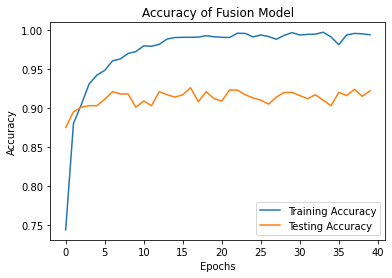

In [ ]:
loss_fn = history_record.history['loss']
val_loss_fn = history_record.history['val_loss']
accuracy_fn = history_record.history['accuracy']
val_accuracy_fn = history_record.history['val_accuracy']
epochs = range(len(history_record.history['loss']))

# Plotting accuracy curve
plt.figure()
plt.plot(epochs, accuracy_fn, label='Training Accuracy')
plt.plot(epochs, val_accuracy_fn, label='Testing Accuracy')
plt.title('Accuracy of Fusion Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

**Model Loss Curve**

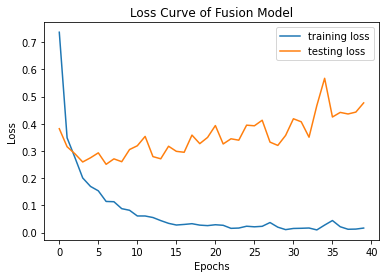

In [ ]:
# Plotting loss curve
plt.figure()
plt.plot(epochs, loss_fn, label='training loss')
plt.plot(epochs, val_loss_fn, label='testing loss')
plt.title('Loss Curve of Fusion Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

**Confusion Matrix**

In [ ]:
# Model prediction for test data
pred = fusion_model.predict(x=[x_test, x_test])

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = []
for i in range(len(y_test)):
    for y in range(8):
        if y_test[i][y]==1:
            y_true.append(y)
            break

y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

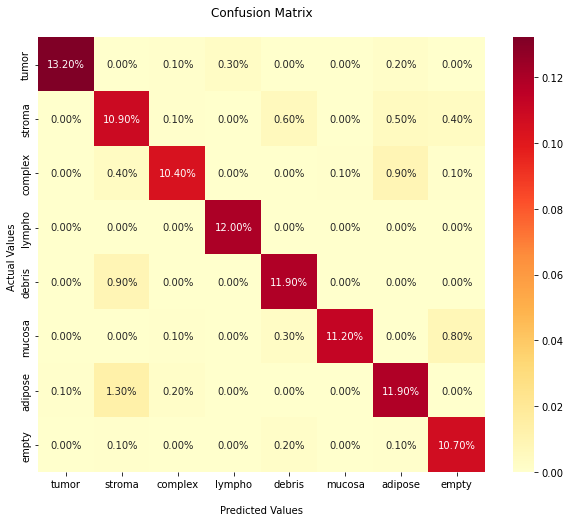

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.875     0.881     0.878       135
     complex      0.954     0.874     0.912       119
      debris      0.915     0.930     0.922       128
       empty      0.892     0.964     0.926       111
      lympho      0.976     1.000     0.988       120
      mucosa      0.991     0.903     0.945       124
      stroma      0.801     0.872     0.835       125
       tumor      0.992     0.957     0.974       138

    accuracy                          0.922      1000
   macro avg      0.925     0.923     0.923      1000
weighted avg      0.925     0.922     0.923      1000

